# Kschool TFM

## Prelude

The goal of this competition is to predict a Windows machine’s probability of getting infected by various families of malware, based on different properties of that machine. The telemetry data containing these properties and the machine infections was generated by combining heartbeat and threat reports collected by Microsoft's endpoint protection solution, Windows Defender.

Each row in this dataset corresponds to a machine, uniquely identified by a MachineIdentifier. HasDetections is the ground truth and indicates that Malware was detected on the machine. Using the information and labels in train.csv, you must predict the value for HasDetections for each machine in test.csv.

## Necessary imports

In [1]:
# disable warnings
import warnings
warnings.filterwarnings("ignore")

In [2]:
# own classes
from Spark import InitSpark
import Resources as resources
import Utilities as utils

In [3]:
# matplotlib
from matplotlib import pyplot as plt
%matplotlib inline

In [4]:
# seaborn
import seaborn as sns

In [5]:
# sklearn and xgboost
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, make_scorer, recall_score, roc_auc_score
from xgboost import XGBClassifier

In [6]:
# pandas
import pandas as pd

In [7]:
# sparkSQL
from pyspark.sql.functions import *
from pyspark.sql.types import *

In [8]:
# sparkML
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.stat import Correlation

## Process Code

In [51]:
## basic configuration

ignore = False # If True, process will ignore fields marked as NA in README.md

score_dict = {
    'precision': make_scorer(precision_score),
    'accuracy': make_scorer(accuracy_score),
    'recall': make_scorer(recall_score),
    'auc' : make_scorer(roc_auc_score)
} # Scores for cross validation searches

classifier_dict = {
    'dtc': DecisionTreeClassifier,
    'rfc': RandomForestClassifier,
    'gbc': GradientBoostingClassifier,
    'xgb': XGBClassifier    
} # Classifiers for cross validation searches

param_grid_dict = {
    'dtc': {
        'max_depth': range(1,10), 
    },
    'rfc': {
        'max_depth': [2, 3, 5, 8, 10, 13, 18],
        'n_estimators': [10, 25, 50, 100]
    },
    'gbc': {
        'max_depth': [2, 3, 5, 8, 10, 13, 18],
        'n_estimators': [10, 25, 50, 100]
    },
    'xgb': {
        'max_depth': [2, 3, 5, 8, 10, 13, 18],
        'n_estimators': [10, 25, 50, 100]
    }    
} # Param grids for cross validation searches

score_refit = 'auc' # The cross validation searches will be refitted against this score. It should be in score_dict
schema = resources.df_schema # Schema from Resources.py for our model
types_default_values = resources.default_values # Default values for each dataType
cv = 5 # Loops in data for cross validation searches
n_iter = 30 # Number of parameter settings that are sampled in RandomizedSearchCV

options = {'header': 'true', 'delimiter': ','} # To read the csv file

In [10]:
def run_model(classifier, x_train, y_train, random=False):
    print("Running for %s" % str(classifier_dict[classifier]))
    if not random:
        model = utils.get_grid_search_cv(classifier=classifier_dict[classifier],
                                   param_grid=param_grid_dict[classifier],
                                   score_dict=score_dict,
                                   score_refit=score_refit,
                                   cv=cv)
    else:
        model = utils.get_randomized_search_cv(classifier=classifier_dict[classifier],
                                         param_grid=param_grid_dict[classifier],
                                         score_dict=score_dict,
                                         score_refit=score_refit,
                                         cv=cv,
                                         n_iter=n_iter)
    
    model.fit(x_train, y_train)
    utils.print_scores(model.cv_results_, scores=score_dict, score_refit=score_refit)
    print("Best Params = %s\n" % str(model.best_params_))
    return model

In [11]:
spark = InitSpark().get_spark_session()
spark

In [12]:
train_df = spark.read.options(**options).schema(schema).csv(resources.train_path)

In [13]:
types = utils.get_input_fields_dict(train_df, 'types')

```
train_df.groupBy(col('HasDetections')).agg(count(lit(1))).show()

+-------------+--------+
|HasDetections|count(1)|
+-------------+--------+
|            1| 4458892|
|            0| 4462591|
+-------------+--------+
```

**column_id**: MachineIdentifier

**x_fields**: Contains all column names in the df except **column_id** and **y_field**

**y_field**: Conatins target column name

**in_model**: Contains all column name in the df that we are going to use in our model. All True this point.

In [14]:
column_id, x_fields, y_field = utils.get_splitted_fields(schema)

In [15]:
in_model = utils.get_input_fields_dict(train_df, 'in_model')

The below variable could be loaded directly from ***Resources***. We only executed it once to avoid expensing so many time in it.
````
different_values = {k: train_df.select(k).distinct().count() for k in in_model.keys()}
````


Now, with **different_values** calculated, we are gonna decide which columns to use as input of our model.

In [ ]:
columns = pd.DataFrame.from_dict(resources.different_values, orient='index', columns=['how_many'])

In [ ]:
columns.describe()

As we can see, a percentage of columns between 50 and 75 percent has no more than 100 different values, so, we are gonna update **in_model** to take only columns with less than 100 different values.

In [ ]:
na_fields = utils.get_na_fields(ignore)

In [ ]:
in_model = {k: True if ((resources.different_values[k] <= 100) and (k not in na_fields)) else False for k in in_model.keys()}

In [16]:
x_fields = utils.get_select_fields(in_model)

In [46]:
sample_train_df = utils.get_sample(train_df, x_fields + [y_field], .1)

Checking if target is still pondered

````
sample_train_df.groupBy(col(y_field)).agg(count(lit(1))).show()
+-------------+--------+
|HasDetections|count(1)|
+-------------+--------+
|            1|  445660|
|            0|  446209|
+-------------+--------+
````

Let's transform to lower case StringType fields:

In [47]:
for field in x_fields:
    if (types[field] == StringType()):
        sample_train_df = sample_train_df.withColumn(field, lower(trim(col(field))))

In [48]:
x_train, y_train = utils.get_x_y_train(sample_train_df, x_fields, y_field)

In [49]:
for field in x_fields:
    x_train[field].fillna(value=resources.default_values[types[field]], inplace=True)
    if (types[field] == StringType()):
        x_train[field] = pd.get_dummies(x_train[field])

## Let's fit our model

As a malware detector, we will use **recall_score** over precision, accuracy or roc_auc scores. In any case, we will execute the 4 scores to verify that the recall is due to a successful criterion.

Running for <class 'sklearn.tree.tree.DecisionTreeClassifier'>
best_precision: 0.57345226, precision_based_on_auc: 0.57139163
best_accuracy: 0.59031909, accuracy_based_on_auc: 0.59031909
best_recall: 0.7675361, recall_based_on_auc: 0.72654494
best_auc: 0.59017482, auc_based_on_auc: 0.59017482


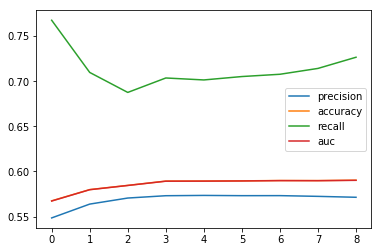

Best Params = {'max_depth': 9}

Running for <class 'sklearn.ensemble.forest.RandomForestClassifier'>


In [ ]:
for classifier in classifier_dict.keys():
#for classifier in ['rfc']:
    model = run_model(classifier, x_train, y_train)

## Coming back

As we can see, our criteria to select columns in our model, has not been so efficient as we want, so we are gonna generate a correlation matrix over full data and take the higher values to select the fields.

In [ ]:
df_default_values = utils.get_input_fields_dict(train_df, \
                                                'default_values', \
                                                default_values=types_default_values)

In [ ]:
train_df = train_df.na.fill(df_default_values)

In [ ]:
for field in in_model.keys():
    if (types[field] == StringType()):
        train_df = train_df.withColumn(field, lower(col(field)))

In [ ]:
string_fields = [field for field in in_model.keys() if types[field] == StringType()]

In [ ]:
index_dict = {field: field + 'Index' for field in string_fields}

In [ ]:
indexers = [StringIndexer(inputCol=x, outputCol=index_dict[x]) for x in string_fields]

In [ ]:
pipeline = Pipeline(stages=indexers)

In [ ]:
train_df_transformed = pipeline.fit(train_df).transform(train_df).drop(column_id)

In [ ]:
for field in string_fields:
    train_df_transformed = train_df_transformed.withColumn(field, col(index_dict[field])).drop(index_dict[field])

In [ ]:
train_df_transformed = train_df_transformed.drop(column_id)

In [ ]:
assembler = VectorAssembler(inputCols=train_df_transformed.columns, outputCol='features')

In [ ]:
correlation_df = assembler.transform(train_df_transformed)

In [ ]:
correlation_matrix = Correlation.corr(correlation_df, "features").head()[0]

In [ ]:
starting_point = (len(train_df_transformed.columns) ** 2) - len(train_df_transformed.columns)

In [ ]:
correlation = utils.get_input_fields_dict(train_df_transformed, \
                                           'correlation', \
                                           correlations=correlation_matrix.values[starting_point:-1])

In [ ]:
correlation_ordered = utils.get_input_fields_dict(train_df_transformed, \
                                                  'correlation_ordered', \
                                                  correlations=correlation_matrix.values[starting_point:-1])

In [ ]:
correlations_pd = pd.DataFrame.from_dict(correlation, orient='index', columns=['correlation'])

In [ ]:
correlations_pd.sort_values("correlation", ascending=False)

### Let's try with topN correlationed fields...

In [ ]:
cut_at = 7

In [ ]:
in_model = {k: ((correlation_ordered[k] < cut_at) and (k not in na_fields)) for k in in_model.keys()}

In [ ]:
x_fields = utils.get_select_fields(in_model)

In [ ]:
sample_train_df = utils.get_sample(train_df_transformed, x_fields + [y_field], .01)

In [ ]:
x_train, y_train = utils.get_x_y_train(sample_train_df, x_fields, y_field)

In [ ]:
for classifier in classifier_dict.keys():
    run_model(classifier, x_train, y_train)

Well... This not improve our metrics so let's analyze data and try to transform some columns...

The code below is comented because we have only executed it once. Output could be see in: 

***Analysis/Data:*** The data will be plotted

***Analysis/Plots/Normal:*** Plotted data in normal scale

***Analysis/Plots/Log:*** Plotted data in log scale

````
for each in in_model.keys():
    train_df.select(each, y_field) \
    .groupBy(col(each), col(y_field)) \
    .agg(count(lit(1)).alias("count")) \
    .repartition(1) \
    .write \
    .options(**options) \
    .csv("Analysis/%s" % each)
````

````
for each in in_model.keys():
    path = "Analysis/Data/%s.csv" % each
    analyzing_df = pd.DataFrame.from_csv(path, index_col=None).sort_values('count', ascending=False)
    for elem in ['Normal', 'Log']:
        if types[each] == StringType():
            f, ax = plt.subplots()
            sns.barplot(y=each, x='count', data=analyzing_df.head(40), hue='HasDetections', ax=ax)
            ax.set_xscale('log') if elem == 'Log' else None
            plt.savefig('Analysis/Plots/%s/%s.png' % (elem, each), dpi=200)
        else:
            analyzing_df = analyzing_df.sort_values(each, ascending=True)
            f, ax = plt.subplots()
            sns.barplot(x=each, y='count', data=analyzing_df.head(40), hue='HasDetections', ax=ax)
            ax.set_yscale('log') if elem == 'Log' else None
            plt.savefig('Analysis/Plots/%s/%s.png' % (elem, each), dpi=200)
            ````


In [ ]:
for field in in_model:
    if types[field] == StringType():
        train_df.withColumn(field, lower(trim(col(field))))

In [ ]:
train_df = train_df.na.fill(df_default_values)

In [ ]:
train_df = train_df \
.withColumn("AVProductsInstalled", when(col("AVProductsInstalled") >= 2, lit(1)).otherwise(lit(0))) \
.withColumn("AVProductStatesIdentifier", col("AVProductStatesIdentifier").cast("string")) \
.withColumn("Census_ChassisTypeName", when(col("Census_ChassisTypeName").isin("notebook", "laptop", "portable", "convertible", "handheld", "tablet", "subnotebook"), lit("portable")).otherwise(lit("no_portable"))) \
.withColumn("Census_DeviceFamily", when(col("Census_DeviceFamily").contains("server"), lit(1)).otherwise(lit(0))) \
.withColumn("Census_FirmwareVersionIdentifier", col("Census_FirmwareVersionIdentifier").cast("string")) \
.withColumn("Census_InternalBatteryType", when(col("Census_InternalBatteryType").contains("li"), lit(1)).otherwise(lit(0))) \
.withColumn("Census_MDC2FormFactor", when(col("Census_MDC2FormFactor").contains("server") | col("Census_MDC2FormFactor").contains("tablet"), lit(1)).otherwise(lit(0))) \
.withColumn("Census_OSArchitecture", when(col("Census_OSArchitecture").contains("arm"), lit(1)).otherwise(lit(0))) \
.withColumn("Census_OSBranch", when(col("Census_OSBranch").contains("release"), lit(1)).otherwise(lit(0))) \
.withColumn("Census_OSBuildRevision", when(col("Census_OSBuildRevision") < 15, lit(1)).otherwise(lit(0))) \
.withColumn("Census_OSEdition", when(col("Census_OSEdition").contains("education") | col("Census_OSEdition").contains("profesional") | col("Census_OSEdition").contains("enterprise"), lit(1)).otherwise(lit(0))) \
.withColumn("Census_OSInstallTypeName", when(col("Census_OSInstallTypeName").contains("clean"), lit(1)).otherwise(lit(0))) \
.withColumn("Census_OSSkuName", when(col("Census_OSSkuName").contains("education") | col("Census_OSSkuName").contains("profesional") | col("Census_OSSkuName").contains("enterprise"), lit(1)).otherwise(lit(0))) \
.withColumn("CityIdentifier", col("CityIdentifier").cast("string")) \
.withColumn("CountryIdentifier", col("CountryIdentifier").cast("string")) \
.withColumn("EngineVersion", when(col("EngineVersion").contains("15100.1") | col("EngineVersion").contains("15300.5"), lit(1)).otherwise(lit(0))) \
.withColumn("Census_InternalBatteryNumberOfCharges", when(col("EngineVersion") > 1, lit(1)).otherwise(lit(0))) \
.withColumn("Census_ProcessorClass", when(col("EngineVersion").isin("mid", "high"), lit(1)).otherwise(lit(0))) \
.withColumn("Census_ProcessorManufacturerIdentifier", col("Census_ProcessorManufacturerIdentifier").cast("string")) \
.withColumn("Census_ProcessorModelIdentifier", col("Census_ProcessorModelIdentifier").cast("string")) \
.withColumn("CityIdentifier", col("CityIdentifier").cast("string")) \
.withColumn("CountryIdentifier", col("CountryIdentifier").cast("string")) \
.withColumn("DefaultBrowsersIdentifier", col("DefaultBrowsersIdentifier").cast("string")) \
.withColumn("SkuEdition", when(col("SkuEdition").contains("education") | col("SkuEdition").contains("profesional") | col("SkuEdition").contains("enterprise"), lit(1)).otherwise(lit(0))) \
.withColumn("SmartScreen", when(col("SmartScreen") == "existsnotset", lit(1)).otherwise(lit(0))) \
.withColumn("GeoNameIdentifier", col("GeoNameIdentifier").cast("string")) \
.withColumn("OsPlatformSubRelease", when(col("OsPlatformSubRelease").contains("windows"), lit(1)).otherwise(lit(0))) \
.withColumn("OsSuite", col("OsSuite").cast("string")) \
.withColumn("Processor", when(col("Processor").contains("arm"), lit(1)).otherwise(lit(0)))

In [ ]:
types = utils.get_input_fields_dict(train_df, 'types')

In [ ]:
string_fields = [field for field in in_model.keys() if types[field] == StringType()]

In [ ]:
index_dict = {field: field + 'Index' for field in string_fields}

In [ ]:
indexers = [StringIndexer(inputCol=x, outputCol=index_dict[x]) for x in string_fields]

In [ ]:
pipeline = Pipeline(stages=indexers)

In [ ]:
train_df_transformed = pipeline.fit(train_df).transform(train_df).drop(column_id)

In [ ]:
for field in string_fields:
    train_df_transformed = train_df_transformed.withColumn(field, col(index_dict[field])).drop(index_dict[field])

In [ ]:
train_df_transformed = train_df_transformed.drop(column_id)

In [ ]:
assembler = VectorAssembler(inputCols=train_df_transformed.columns, outputCol='features')

In [ ]:
correlation_df = assembler.transform(train_df_transformed)

In [ ]:
correlation_matrix = Correlation.corr(correlation_df, "features").head()[0]

In [ ]:
starting_point = (len(train_df_transformed.columns) ** 2) - len(train_df_transformed.columns)

In [ ]:
correlation = utils.get_input_fields_dict(train_df_transformed, \
                                           'correlation', \
                                           correlations=correlation_matrix.values[starting_point:-1])

In [ ]:
correlation_ordered = utils.get_input_fields_dict(train_df_transformed, \
                                                  'correlation_ordered', \
                                                  correlations=correlation_matrix.values[starting_point:-1])

In [ ]:
correlations_pd = pd.DataFrame.from_dict(correlation, orient='index', columns=['correlation'])

In [ ]:
correlations_pd.sort_values("correlation", ascending=False)

### Let's try again...

In [ ]:
cut_at = 15

In [ ]:
in_model = {k: ((correlation_ordered[k] < cut_at) and (k not in na_fields)) for k in in_model.keys()}

In [ ]:
x_fields = utils.get_select_fields(in_model)

In [ ]:
sample_train_df = utils.get_sample(train_df_transformed, x_fields + [y_field], .01)

In [ ]:
x_train, y_train = utils.get_x_y_train(sample_train_df, x_fields, y_field)

In [ ]:
for classifier in classifier_dict.keys():
    run_model(classifier, x_train, y_train)

{'mean_fit_time': array([ 0.82388883,  1.82274995,  3.37239184,  5.5269393 ,  1.57464409,
         2.30795383,  4.2614934 ,  7.11574516,  1.98110318,  3.28127613,
         5.52618585,  9.78342795,  2.26961875,  4.39859691,  7.70316825,
        13.98647919,  2.52329092,  4.96562009,  9.19491835, 16.80665793,
         2.9888289 ,  5.8818264 , 11.09205489, 20.94132552,  3.60588179,
         7.52192311, 14.31080155, 23.41928859]),
 'std_fit_time': array([0.1227314 , 0.04488946, 0.15725897, 0.176884  , 0.07047444,
        0.07319819, 0.20650324, 0.26487015, 0.12316098, 0.02436092,
        0.11160958, 0.09672695, 0.07346868, 0.04691934, 0.14080255,
        0.15393206, 0.04547436, 0.06063308, 0.13359939, 0.16065103,
        0.05626555, 0.06556464, 0.13480616, 0.10429334, 0.07493702,
        0.06210478, 0.13670827, 2.50866296]),
 'mean_score_time': array([0.57266574, 0.87923226, 1.05519986, 1.51714053, 0.75530157,
        0.85558453, 1.24887152, 1.66334162, 0.87938623, 0.97324829,
        1.17

In [37]:
values = {k:v for k,v in zip(in_model.keys(), model.best_estimator_.feature_importances_)

In [40]:
result = {k: values[k] for v, k in enumerate(sorted(values, key=values.get, reverse=True))}

In [42]:
select_fields = list(result.keys())[:3]

In [45]:
x_fields = select_fields